In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop, adadelta, Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

/home/praneet/envs/deeplearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_rows = 80
img_cols = 80
num_channels = 3
epochs = 50
num_classes = 3
batch_size = 16
NAME = "depth_" + str(epochs)
directory = '../IP/ignore/dataset/balanced/'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    zca_whitening=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory, # same directory as training data
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation') # set as validation data

/home/praneet/envs/deeplearning/lib/python3.5/site-packages/keras_preprocessing/image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 13155 images belonging to 3 classes.
Found 3287 images belonging to 3 classes.


In [4]:
tensorboard = TensorBoard(log_dir = 'logs/' + NAME)

In [5]:
augmented_checkpoint = ModelCheckpoint('models/augmented_best_model.h5',  # model filename
                                       monitor='val_loss',  # quantity to monitor
                                       verbose=1,  # verbosity - 0 or 1
                                       save_best_only=True,  # The latest best model will not be overwritten
                                       mode='auto')

In [6]:
model = Sequential()

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=(img_rows, img_rows, num_channels)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 76, 76, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
__________

In [7]:
model.compile(loss=keras.losses.categorical_crossentropy,  # Better loss function for neural networks
              optimizer=Adam(lr=0.001, decay=1e-6),  # Adam optimizer with 1.0e-4 learning rate
              metrics=['accuracy'])  # Metrics to be evaluated by the model

In [8]:
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks=[augmented_checkpoint, tensorboard],
                    verbose=1,
                    steps_per_epoch=64,
                    validation_steps=32,
)

Epoch 1/50


/home/praneet/envs/deeplearning/lib/python3.5/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/praneet/envs/deeplearning/lib/python3.5/site-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


64/64 [==============================] - 53s 836ms/step - loss: 1.1057 - acc: 0.3203 - val_loss: 1.0982 - val_acc: 0.3340

Epoch 00001: val_loss improved from inf to 1.09824, saving model to models/augmented_best_model.h5
Epoch 2/50
64/64 [==============================] - 42s 652ms/step - loss: 1.0984 - acc: 0.3545 - val_loss: 1.0964 - val_acc: 0.3711

Epoch 00002: val_loss improved from 1.09824 to 1.09638, saving model to models/augmented_best_model.h5
Epoch 3/50
64/64 [==============================] - 43s 667ms/step - loss: 1.0973 - acc: 0.3570 - val_loss: 1.0969 - val_acc: 0.3438

Epoch 00003: val_loss did not improve from 1.09638
Epoch 4/50
64/64 [==============================] - 41s 648ms/step - loss: 1.0999 - acc: 0.3193 - val_loss: 1.0994 - val_acc: 0.3184

Epoch 00004: val_loss did not improve from 1.09638
Epoch 5/50
64/64 [==============================] - 42s 650ms/step - loss: 1.0940 - acc: 0.3428 - val_loss: 1.1030 - val_acc: 0.3242

Epoch 00005: val_loss did not improve

64/64 [==============================] - 41s 642ms/step - loss: 1.0969 - acc: 0.3564 - val_loss: 1.1003 - val_acc: 0.3496

Epoch 00044: val_loss did not improve from 1.09040
Epoch 45/50
64/64 [==============================] - 41s 642ms/step - loss: 1.0965 - acc: 0.3311 - val_loss: 1.0934 - val_acc: 0.3730

Epoch 00045: val_loss did not improve from 1.09040
Epoch 46/50
64/64 [==============================] - 41s 642ms/step - loss: 1.0928 - acc: 0.3525 - val_loss: 1.0962 - val_acc: 0.3221

Epoch 00046: val_loss did not improve from 1.09040
Epoch 47/50
64/64 [==============================] - 41s 642ms/step - loss: 1.1020 - acc: 0.3232 - val_loss: 1.0952 - val_acc: 0.3691

Epoch 00047: val_loss did not improve from 1.09040
Epoch 48/50
64/64 [==============================] - 41s 643ms/step - loss: 1.0958 - acc: 0.3428 - val_loss: 1.0972 - val_acc: 0.3418

Epoch 00048: val_loss did not improve from 1.09040
Epoch 49/50
64/64 [==============================] - 41s 642ms/step - loss: 1.0952

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/model.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.preprocessing import image

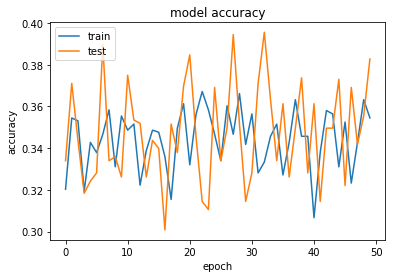

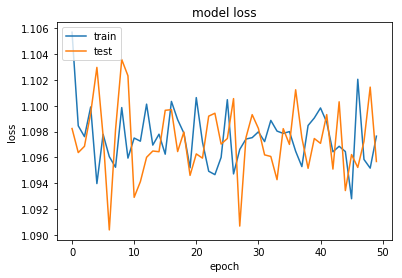

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

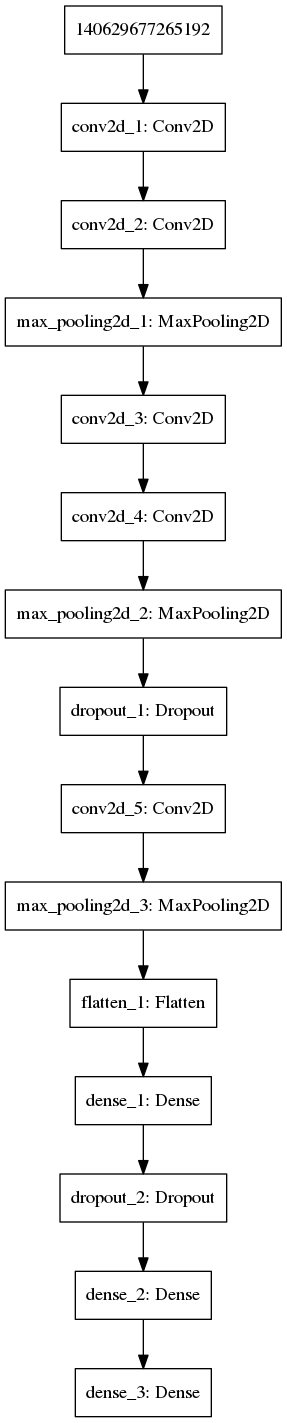

In [12]:
from keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='model.png')
Image.open('model.png')